#Assignment Target

Test Accuracy: 99.4

Total Number of Parameters: 8000

#Results obtained in Fifth Submission

Best Test Accuracy: 99.15

Number of Parameters Used: 7770

#Analysis - Receptive Field & other dimension calculations

We have added a little bit image augmentation to increase variability in training and to reduce amount of overfitting. The RF and other calculations remain same as we are not adding any extra layers. 

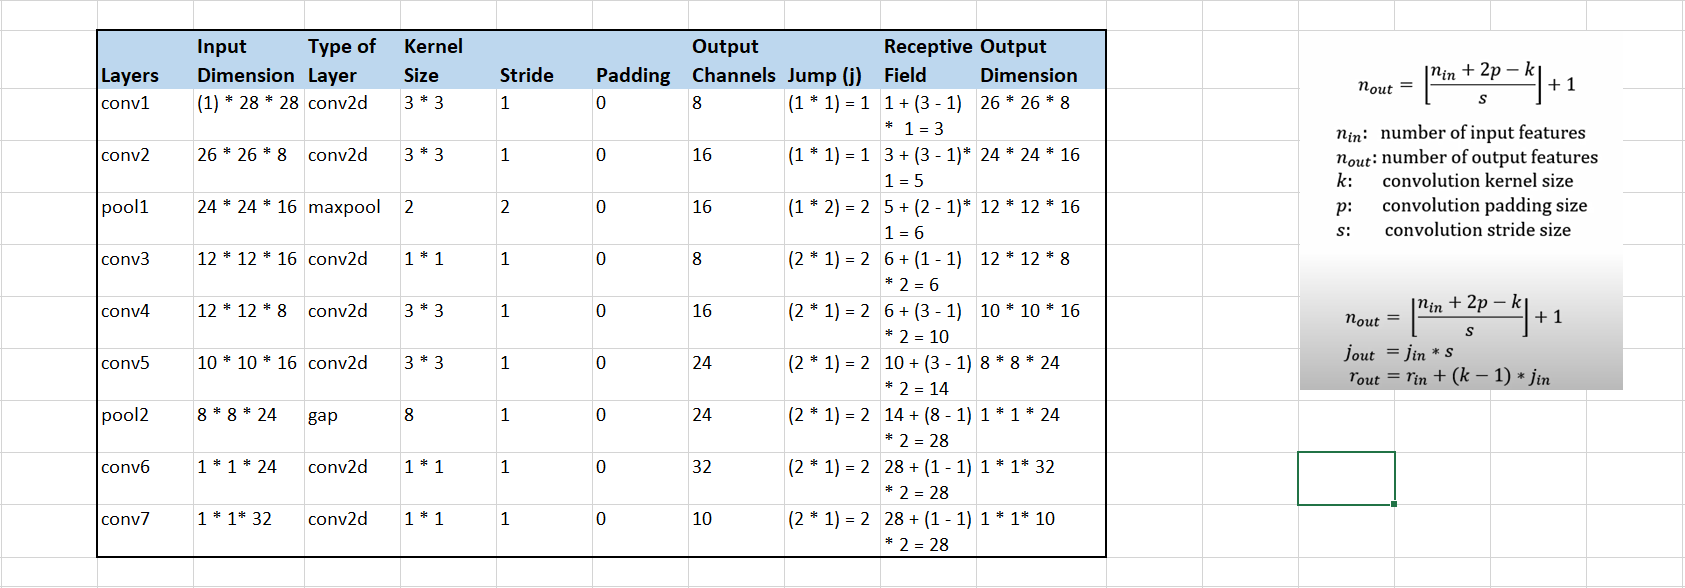

#Analysis - Train Accuracy Comparison between Without and With Image Augmentation

Train accuracy is almost comparable but a little consistent lower.

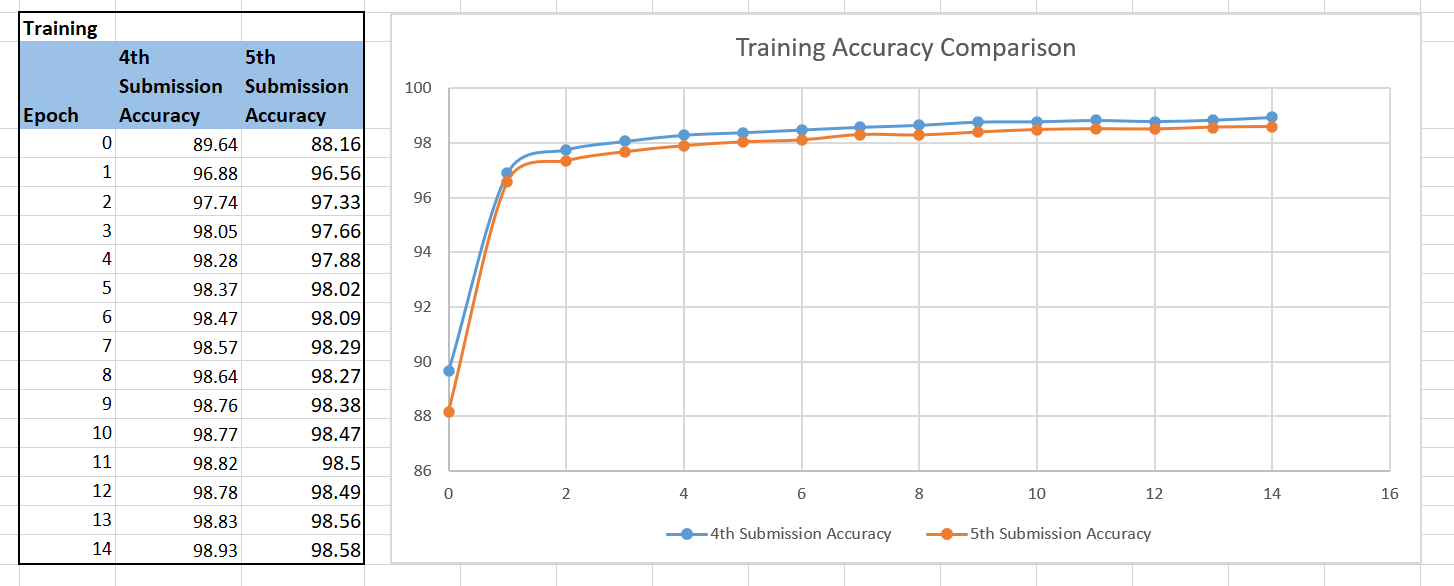

#Analysis - Test Accuracy Comparison between Without Augmented and With Augmented Data

Test Accuracy seemed improved and was coming around consistent around 99 and above from 7th epoch. This indicates a stable model for inference, although we haven't yet reached the test accuracy target. We would do certain more optimizations around our model in the coming submissions.


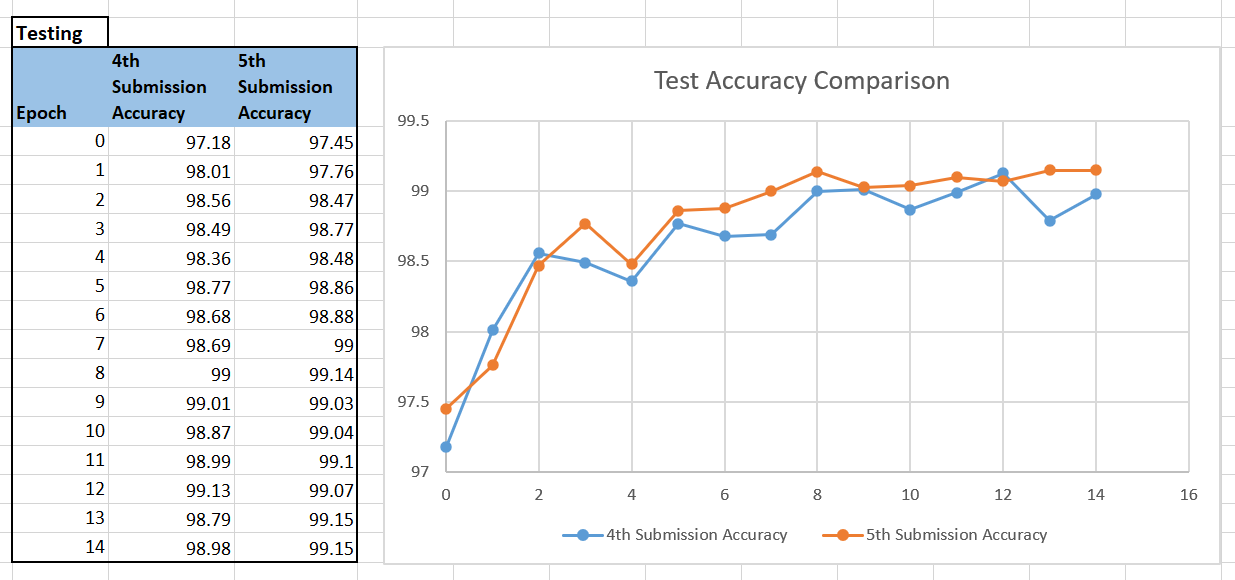

#Comments

1. One obvious model performance improvement we can see. The test accuracy hasn't ever come down below 99 percent after epoch number 7. This indicates, the inference accuracy is not by chance, rather the model consistently improved.

2. Still we have not touched target test accuracy, so we would do further optimizations and would observe the result in next submissions.

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3) # 26 * 26 * 8
        self.bn1 = nn.BatchNorm2d(8) # 26 * 26 * 8
        self.conv2 = nn.Conv2d(8, 16, 3) # 24 * 24 * 16
        self.bn2 = nn.BatchNorm2d(16) # 24 * 24 * 16
        self.pool1 = nn.MaxPool2d(2, 2) # 12 * 12 * 16
        self.conv3 = nn.Conv2d(16, 8, 1) # 12 * 12 * 8
        self.bn3 = nn.BatchNorm2d(8) # 12 * 12 * 8

        self.conv4 = nn.Conv2d(8, 16, 3) # 10 * 10 * 16
        self.bn4 = nn.BatchNorm2d(16) # 10 * 10 * 16
        self.conv5 = nn.Conv2d(16, 24, 3) # 8 * 8 * 24
        self.bn5 = nn.BatchNorm2d(24) # 8 * 8 * 24
        self.pool2 = nn.AvgPool2d(8) # 1 * 1 * 24

        self.conv6 = nn.Conv2d(24, 32, 1) # 1 * 1 * 32
        self.bn6 = nn.BatchNorm2d(32) # 1 * 1 * 32
        self.conv7 = nn.Conv2d(32, 16, 1) # 1 * 1 * 16
        self.bn7 = nn.BatchNorm2d(16) # 1 * 1 * 16
        self.conv8 = nn.Conv2d(16, 10, 1) # 1 * 1 * 10

        self.dropout = nn.Dropout(0.05)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.dropout(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.dropout(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.bn5(x)
        x = self.dropout(x)
        x = self.pool2(x)

        x = self.conv6(x)
        x = F.relu(x)
        x = self.bn6(x)
        x = self.dropout(x)

        x = self.conv7(x)
        x = F.relu(x)
        x = self.bn7(x)
        x = self.dropout(x)

        x = self.conv8(x)

        '''
        x = nn.Dropout(self.bn3(self.conv3(self.pool1(nn.Dropout(self.bn2(self.conv2(F.relu(nn.Dropout(self.bn1(self.conv1(x)), 0.05)))), 0.05)))), 0.05)
        x = self.pool2(nn.Dropout(self.bn5(F.relu(self.conv5(nn.Dropout(self.bn4(F.relu(self.conv4(x))), 0.05)))), 0.05)),
        x = self.conv8(nn.Dropout(self.bn7(F.relu(self.conv7(nn.Dropout(self.bn6(F.relu(self.conv6(x))), 0.05)))), 0.05))
        '''
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,168
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             136
       BatchNorm2d-9            [-1, 8, 12, 12]              16
          Dropout-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,168
      BatchNorm2d-12           [-1, 16, 10, 10]              32

# Training and Testing

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.2732337415218353 Batch_id=468 Accuracy=88.16: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]



Test set: Average loss: 0.0872, Accuracy: 9745/10000 (97.45%)

EPOCH: 1


Loss=0.16329407691955566 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0748, Accuracy: 9776/10000 (97.76%)

EPOCH: 2


Loss=0.04289648309350014 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]



Test set: Average loss: 0.0474, Accuracy: 9847/10000 (98.47%)

EPOCH: 3


Loss=0.11414932459592819 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]



Test set: Average loss: 0.0401, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.03618963062763214 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]



Test set: Average loss: 0.0491, Accuracy: 9848/10000 (98.48%)

EPOCH: 5


Loss=0.07262670248746872 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:16<00:00, 27.86it/s]



Test set: Average loss: 0.0388, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.10475189238786697 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]



Test set: Average loss: 0.0370, Accuracy: 9888/10000 (98.88%)

EPOCH: 7


Loss=0.014746402390301228 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:16<00:00, 27.62it/s]



Test set: Average loss: 0.0315, Accuracy: 9900/10000 (99.00%)

EPOCH: 8


Loss=0.07913126051425934 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]



Test set: Average loss: 0.0305, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.015233825892210007 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]



Test set: Average loss: 0.0322, Accuracy: 9903/10000 (99.03%)

EPOCH: 10


Loss=0.023798728361725807 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss: 0.0301, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.07839823514223099 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]



Test set: Average loss: 0.0270, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.16510041058063507 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0317, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


Loss=0.014580834656953812 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 27.67it/s]



Test set: Average loss: 0.0274, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.012958255596458912 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]



Test set: Average loss: 0.0276, Accuracy: 9915/10000 (99.15%)

